In [1]:
import gdal
import h5py
import numpy as np
from math import floor
import os
import matplotlib.pyplot as plt


Lesson materials for day 3 on LiDAR uncertainty at PRIN

In [2]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(diff_dsm_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)
    

In [3]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [4]:
dsm1_filename='/Users/kdw223/Desktop/NEON_day3/data/PRIN/2016_PRIN_1_607000_3696000_DSM.tif'
dsm2_filename='/Users/kdw223/Desktop/NEON_day3/data/PRIN/2016_PRIN_2_607000_3696000_DSM.tif'
dtm1_filename='/Users/kdw223/Desktop/NEON_day3/data/PRIN/2016_PRIN_1_607000_3696000_DTM.tif'
dtm2_filename='/Users/kdw223/Desktop/NEON_day3/data/PRIN/2016_PRIN_2_607000_3696000_DTM.tif'
chm_filename='/Users/kdw223/Desktop/NEON_day3/data/PRIN/2016_PRIN_1_607000_3696000_pit_free_CHM.tif'

Use the raster to array function to read in raster files

In [5]:
dsm1_array, dsm1_array_metadata = raster2array(dsm1_filename)
dsm2_array, dsm2_array_metadata = raster2array(dsm2_filename)
dtm1_array, dtm1_array_metadata = raster2array(dtm1_filename)
dtm2_array, dtm2_array_metadata = raster2array(dtm2_filename)
chm_array, chm_array_metadata = raster2array(chm_filename)

Check the difference between the two days:

In [6]:
diff_dsm_array = np.subtract(dsm1_array,dsm2_array)
diff_dtm_array = np.subtract(dtm1_array,dtm2_array) 

In [7]:
diff_dsm_array_mean = np.mean(diff_dsm_array)
diff_dsm_array_std = np.std(diff_dsm_array)
print('Mean difference in DSMs: ',round(diff_dsm_array_mean,3),' (m)')
print('Standard deviations of difference in DSMs: ',round(diff_dsm_array_std,3),' (m)')

Mean difference in DSMs:  0.019  (m)
Standard deviations of difference in DSMs:  0.743  (m)


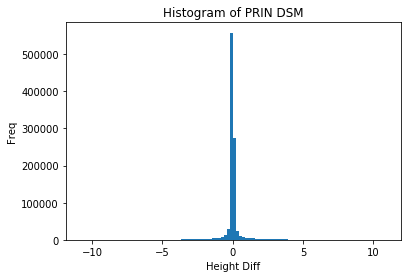

In [8]:
plt.figure(1)
plt.hist(diff_dsm_array.flatten(), 100);
plt.title('Histogram of PRIN DSM');
plt.xlabel('Height Diff'); plt.ylabel('Freq');

Text(0,0.5,'Frequency')

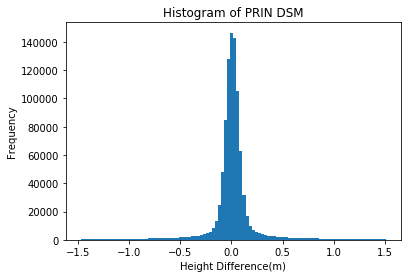

In [9]:
plt.figure(1)
plt.hist(diff_dsm_array.flatten(),100,range=[diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std])
plt.title('Histogram of PRIN DSM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

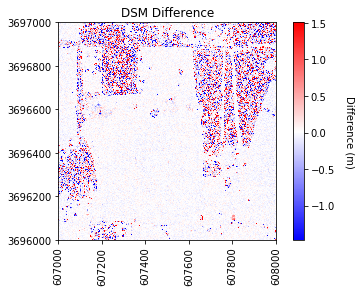

In [10]:
plt.figure(3)
plot_band_array(diff_dsm_array,dsm1_array_metadata['extent'],'DSM Difference','Difference (m)','bwr',
                [diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std])
plt.show()

In [11]:
diff_dtm_array_mean = np.mean(diff_dtm_array)
diff_dtm_array_std = np.std(diff_dtm_array)
print('Mean difference in DTMs: ',round(diff_dtm_array_mean,3),' (m)')
print('Standard deviations of difference in DTMs: ',round(diff_dtm_array_std,3),' (m)')

Mean difference in DTMs:  0.014  (m)
Standard deviations of difference in DTMs:  0.102  (m)


Text(0,0.5,'Frequency')

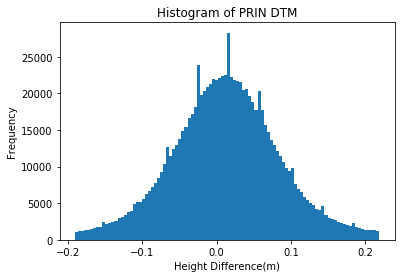

In [12]:
plt.figure(4)
plt.hist(diff_dtm_array.flatten(),100,
         range=[diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.title('Histogram of PRIN DTM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

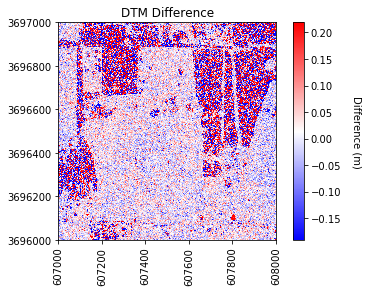

In [13]:
plt.figure(5)
plot_band_array(diff_dtm_array,dtm1_array_metadata['extent'],'DTM Difference','Difference (m)','bwr',
                [diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.show()

Mean difference in DTMs:  0.014  (m)
Standard deviations of difference in DTMs:  0.102  (m)


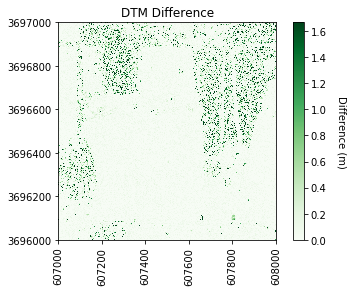

In [14]:
chm_array_mean = np.nanmean(chm_array)
chm_array_std = np.std(chm_array)
print('Mean difference in DTMs: ',round(diff_dtm_array_mean,3),' (m)')
print('Standard deviations of difference in DTMs: ',round(diff_dtm_array_std,3),' (m)')
plt.figure(5)
plot_band_array(chm_array,chm_array_metadata['extent'],'DTM Difference','Difference (m)','Greens',
                [0, chm_array_mean])
plt.show()

In [15]:
diff_dsm_array_veg_mean=np.nanmean(diff_dsm_array[chm_array!=0])
diff_dsm_array_veg_std=np.std(diff_dsm_array[chm_array!=0])
print('Mean difference in DSMs at Veg Points: ',round(diff_dsm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DSMs at Veg Points: ',round(diff_dsm_array_veg_std,3),' (m)')


Mean difference in DSMs at Veg Points:  0.064  (m)
Standard deviations of difference in DSMs at Veg Points:  1.381  (m)


Text(0,0.5,'Frequency')

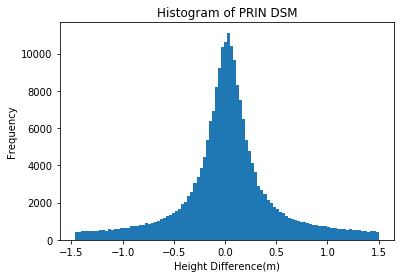

In [16]:
plt.figure(4)
plt.hist(diff_dsm_array[chm_array!=0].flatten(),100, 
         [diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std])
plt.title('Histogram of PRIN DSM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

In [17]:
diff_dtm_array_veg_mean=np.nanmean(diff_dtm_array[chm_array!=0])
diff_dtm_array_veg_std=np.std(diff_dtm_array[chm_array!=0])
print('Mean difference in DTMs at Veg Points: ',round(diff_dtm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DTMs at Veg Points: ',round(diff_dtm_array_veg_std,3),' (m)')


Mean difference in DTMs at Veg Points:  0.023  (m)
Standard deviations of difference in DTMs at Veg Points:  0.163  (m)


Text(0,0.5,'Frequency')

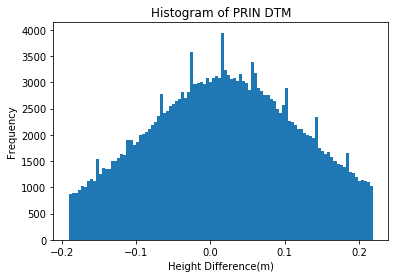

In [18]:
plt.figure(4)
plt.hist(diff_dtm_array[chm_array!=0].flatten(),100, 
         [diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.title('Histogram of PRIN DTM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

In [21]:
diff_dtm_array_noveg_mean=np.nanmean(diff_dtm_array[chm_array==0])
diff_dtm_array_noveg_std=np.std(diff_dtm_array[chm_array==0])
print('Mean difference in DTMs Excluding Veg Points: ',round(diff_dtm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DTMs Excluding Veg Points: ',round(diff_dtm_array_veg_std,3),' (m)')

Mean difference in DTMs Excluding Veg Points:  0.011  (m)
Standard deviations of difference in DTMs Excluding Veg Points:  0.068  (m)


Text(0,0.5,'Frequency')

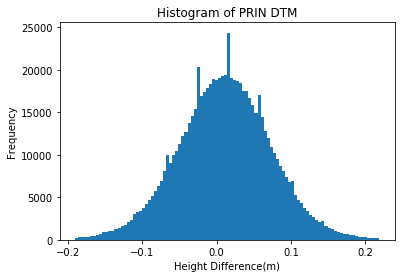

In [22]:
plt.figure(4)
plt.hist(diff_dtm_array[chm_array==0].flatten(),100, 
         [diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.title('Histogram of PRIN DTM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')